## How to Implement Learning to Rank Model using Python

In [4]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing,model_selection,metrics
from lightgbm import LGBMRanker

warnings.filterwarnings('ignore')

In [75]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.3 MB/s eta 0:00:00


In [5]:
from tabulate import tabulate
from functools import wraps

def print_tabulate(df):
        if isinstance(df, pd.DataFrame):
            print(tabulate(df, headers='keys', tablefmt='psql'))
        else:
            return df


In [6]:
!kaggle datasets download -d ransakaravihara/anime-recommendation-ltr-dataset

Dataset URL: https://www.kaggle.com/datasets/ransakaravihara/anime-recommendation-ltr-dataset
License(s): CC0-1.0
anime-recommendation-ltr-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
zipped_data = zipfile.ZipFile("anime-recommendation-ltr-dataset.zip")

In [8]:
zipped_data.namelist()

['anime_info.csv', 'relavence_scores.csv', 'user_info.csv']

In [9]:
anime_info_df = pd.read_csv(zipped_data.open('anime_info.csv'))
relavence_scores = pd.read_csv(zipped_data.open('relavence_scores.csv'))
user_info = pd.read_csv(zipped_data.open('user_info.csv'))

In [10]:
anime_info_df.info()
anime_info_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16681 entries, 0 to 16680
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   anime_id                 16681 non-null  int64  
 1   Genres                   16627 non-null  object 
 2   is_tv                    16681 non-null  int64  
 3   year_aired               16558 non-null  float64
 4   is_adult                 16681 non-null  int64  
 5   above_five_star_users    5669 non-null   float64
 6   above_five_star_ratings  5669 non-null   float64
 7   above_five_star_ratio    5669 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


,anime_id,Genres,is_tv,year_aired,is_adult,above_five_star_users,above_five_star_ratings,above_five_star_ratio
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",1,1998.0,1,4012.0,4012.0,0.594018
1,5,"Action, Drama, Mystery, Sci-Fi, Space",0,2001.0,1,NaN,NaN,NaN


In [11]:
relavence_scores = relavence_scores[~(relavence_scores['user_id']==11100)]
relavence_scores.info()
relavence_scores.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 4864759 entries, 0 to 4878998
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   anime_id         int64  
 1   Name             object 
 2   user_id          int64  
 3   relavence_score  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 185.6+ MB


,anime_id,Name,user_id,relavence_score
0,1,Cowboy Bebop,3,1.000000
1,1,Cowboy Bebop,6,1.000000
2,1,Cowboy Bebop,8,0.230769


In [12]:
user_info.info()
user_info.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15163 entries, 0 to 15162
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                15163 non-null  int64  
 1   review_count           15163 non-null  int64  
 2   avg_score              15163 non-null  float64
 3   score_stddev           15023 non-null  float64
 4   above_five_star_count  8631 non-null   float64
 5   above_five_star_ratio  8631 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 710.9 KB


,user_id,review_count,avg_score,score_stddev,above_five_star_count,above_five_star_ratio
0,3,357,6.801120,2.475089,318.0,0.890756
1,6,545,4.089908,3.731472,285.0,0.522936


Alright, let me explain the methodology I am going to use here. Unlike search engine data, we don't have query and document pairs in this use case. So we will treat users as queries and the animes they are interested in as documents. One search query can be associated with multiple documents; users can interact with many animes.

The target label we predict here is relevance_score, stored in the relevance_scores dataset. When we build a raking model, it will learn a function to rank those anime into an optimum order where the highest relevant anime comes first for each user.

Next, we need to create a dataset by joining the above three datasets. I will also create new features based on anime and user features. Let's create a dataset.

In [13]:
popular_genres = ['Comedy',
 'Action',
 'Fantasy',
 'Adventure',
 'Kids',
 'Drama',
 'Sci-Fi',
 'Music',
 'Shounen',
 'Slice of Life']

In [14]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def create_genre_flags(df, popular_genres):
    # drop the rows if null value in Genres column
    df = df.dropna(subset=['Genres'])
    df['Genres'] = df['Genres'].apply(lambda x:",".join(s.strip() for s in x.split(",")))
    # use MultiLabelBinarizer to create a one-hot encoded dataframe of the genres
    mlb = MultiLabelBinarizer()
    genre_df = pd.DataFrame(mlb.fit_transform(df['Genres'].str.split(',')),
                            columns=mlb.classes_,
                            index=df.index)
    # create a new dataframe with the movie id and genre columns
    new_df = pd.concat([df['anime_id'], genre_df[popular_genres]], axis=1)
    new_df.columns = ['anime_id'] + popular_genres
    return new_df

In [15]:
anime_info_df["Genres"].isnull().sum()

54

In [16]:
anime_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16681 entries, 0 to 16680
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   anime_id                 16681 non-null  int64  
 1   Genres                   16627 non-null  object 
 2   is_tv                    16681 non-null  int64  
 3   year_aired               16558 non-null  float64
 4   is_adult                 16681 non-null  int64  
 5   above_five_star_users    5669 non-null   float64
 6   above_five_star_ratings  5669 non-null   float64
 7   above_five_star_ratio    5669 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [17]:
anime_genre_info_df = create_genre_flags(anime_info_df,popular_genres)

In [18]:
anime_genre_info_df.info()
anime_genre_info_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 16627 entries, 0 to 16680
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   anime_id       16627 non-null  int64
 1   Comedy         16627 non-null  int64
 2   Action         16627 non-null  int64
 3   Fantasy        16627 non-null  int64
 4   Adventure      16627 non-null  int64
 5   Kids           16627 non-null  int64
 6   Drama          16627 non-null  int64
 7   Sci-Fi         16627 non-null  int64
 8   Music          16627 non-null  int64
 9   Shounen        16627 non-null  int64
 10  Slice of Life  16627 non-null  int64
dtypes: int64(11)
memory usage: 1.5 MB


,anime_id,Comedy,Action,Fantasy,Adventure,Kids,Drama,Sci-Fi,Music,Shounen,Slice of Life
0,1,1,1,0,1,0,1,1,0,0,0
1,5,0,1,0,0,0,1,1,0,0,0


In [19]:
anime_info_df.info()
anime_genre_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16681 entries, 0 to 16680
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   anime_id                 16681 non-null  int64  
 1   Genres                   16627 non-null  object 
 2   is_tv                    16681 non-null  int64  
 3   year_aired               16558 non-null  float64
 4   is_adult                 16681 non-null  int64  
 5   above_five_star_users    5669 non-null   float64
 6   above_five_star_ratings  5669 non-null   float64
 7   above_five_star_ratio    5669 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 16627 entries, 0 to 16680
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   anime_id       16627 non-null  int64
 1   Comedy         16627 non-null  int64
 2   Action       

In [20]:
anime_info_df_final = anime_info_df.merge(anime_genre_info_df,on='anime_id', how="inner")

In [21]:
del anime_info_df_final['Genres']

In [22]:
anime_info_df_final.head(2)

,anime_id,is_tv,year_aired,is_adult,above_five_star_users,above_five_star_ratings,above_five_star_ratio,Comedy,Action,Fantasy,Adventure,Kids,Drama,Sci-Fi,Music,Shounen,Slice of Life
0,1,1,1998.0,1,4012.0,4012.0,0.594018,1,1,0,1,0,1,1,0,0,0
1,5,0,2001.0,1,NaN,NaN,NaN,0,1,0,0,0,1,1,0,0,0


In [23]:
anime_info_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16627 entries, 0 to 16626
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   anime_id                 16627 non-null  int64  
 1   is_tv                    16627 non-null  int64  
 2   year_aired               16505 non-null  float64
 3   is_adult                 16627 non-null  int64  
 4   above_five_star_users    5655 non-null   float64
 5   above_five_star_ratings  5655 non-null   float64
 6   above_five_star_ratio    5655 non-null   float64
 7   Comedy                   16627 non-null  int64  
 8   Action                   16627 non-null  int64  
 9   Fantasy                  16627 non-null  int64  
 10  Adventure                16627 non-null  int64  
 11  Kids                     16627 non-null  int64  
 12  Drama                    16627 non-null  int64  
 13  Sci-Fi                   16627 non-null  int64  
 14  Music                 

In [24]:
anime_info_df_final.columns = [col if col=='anime_id' else f"ANIME_FEATURE {col}".upper() for col in anime_info_df_final.columns]
anime_info_df_final.columns

Index(['anime_id', 'ANIME_FEATURE IS_TV', 'ANIME_FEATURE YEAR_AIRED',
       'ANIME_FEATURE IS_ADULT', 'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE COMEDY',
       'ANIME_FEATURE ACTION', 'ANIME_FEATURE FANTASY',
       'ANIME_FEATURE ADVENTURE', 'ANIME_FEATURE KIDS', 'ANIME_FEATURE DRAMA',
       'ANIME_FEATURE SCI-FI', 'ANIME_FEATURE MUSIC', 'ANIME_FEATURE SHOUNEN',
       'ANIME_FEATURE SLICE OF LIFE'],
      dtype='object')

In [25]:
user_info.columns = [col if col=='user_id' else f"USER_FEATURE {col}".upper() for col in user_info.columns]
user_info.columns

Index(['user_id', 'USER_FEATURE REVIEW_COUNT', 'USER_FEATURE AVG_SCORE',
       'USER_FEATURE SCORE_STDDEV', 'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
       'USER_FEATURE ABOVE_FIVE_STAR_RATIO'],
      dtype='object')

In [26]:
import matplotlib as mpl

def create_histogram(data, xname, n_bins=100, background_color='#F3F3F3', title=None):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'sans-serif'
    # mpl.rcParams['font.weight'] = 'semibold'

    plt.figure(figsize=(10,8))
    plt.hist(data, bins=n_bins, color='#2596be', edgecolor='black')
    plt.xlabel(xname)
    plt.ylabel('Frequency')
    ax = plt.gca()
    ax.set_facecolor(background_color)
    plt.grid(True, which='both', color='lightgray', linewidth=0.5)
    plt.title(title.upper(),fontweight='semibold',fontfamily='sans-serif')
    plt.show()

In [27]:
relavence_scores.head(2)

,anime_id,Name,user_id,relavence_score
0,1,Cowboy Bebop,3,1.0
1,1,Cowboy Bebop,6,1.0


Let's quickly check a few statistics of our dataset. In total, there are 4.8Mn user-anime interactions, 15K users, and 16K animes in the dataset.

Here is the user and anime interaction distribution.

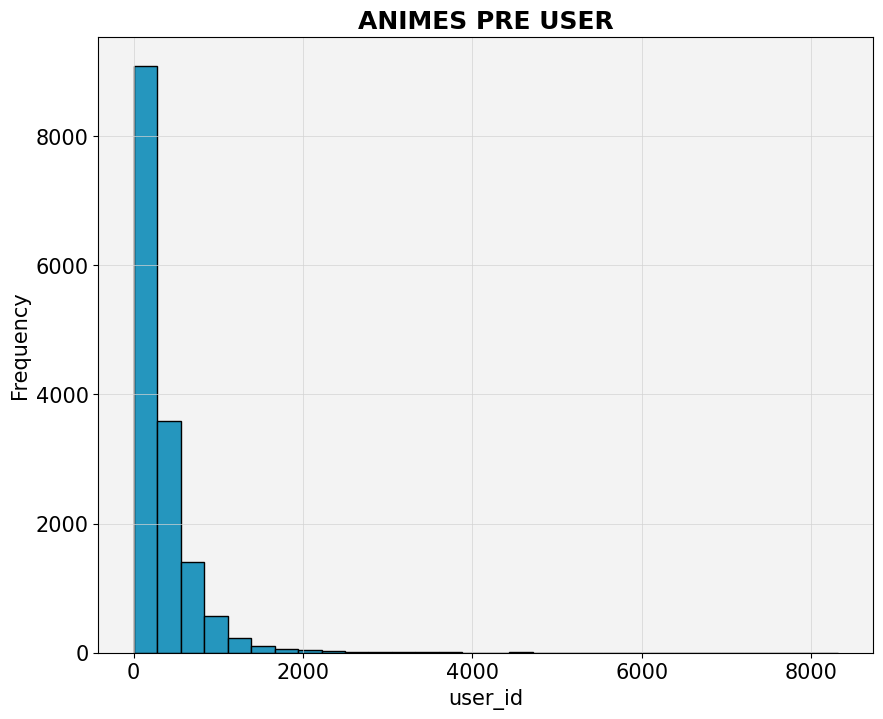

In [28]:
create_histogram(relavence_scores.groupby("user_id").size(),xname='user_id', n_bins=30, title='Animes pre user')

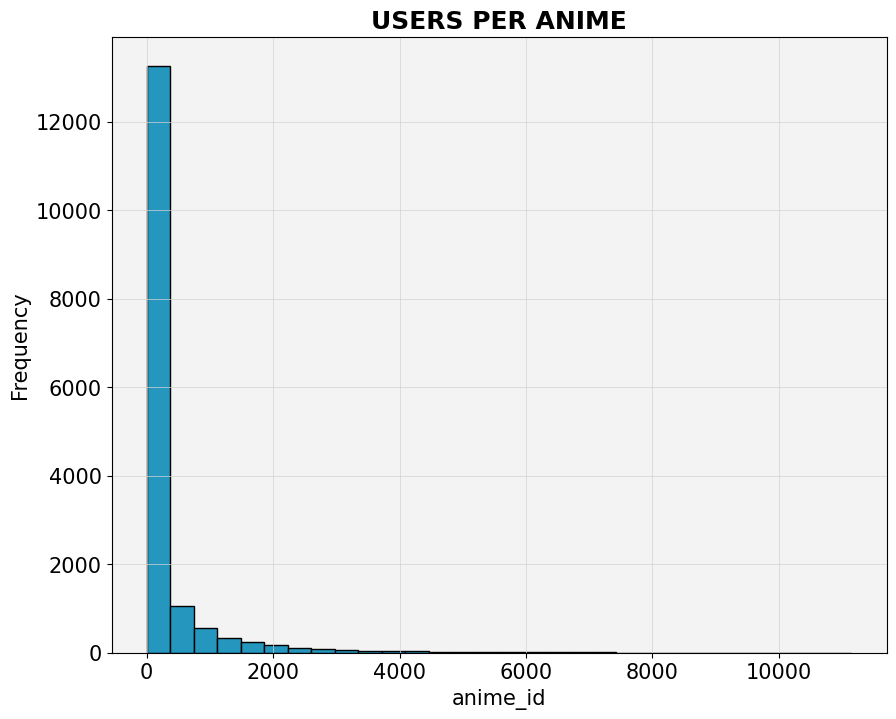

In [29]:
create_histogram(relavence_scores.groupby("anime_id")['anime_id'].agg('count'),xname='anime_id', n_bins=30, title='Users per anime')

In [30]:
f"""there are {relavence_scores['user_id'].nunique():,.0f} unique users and {relavence_scores['anime_id'].nunique():,.0f} unique animes and {len(relavence_scores):,.0f} user-anime interactions"""

'there are 15,162 unique users and 16,109 unique animes and 4,864,759 user-anime interactions'

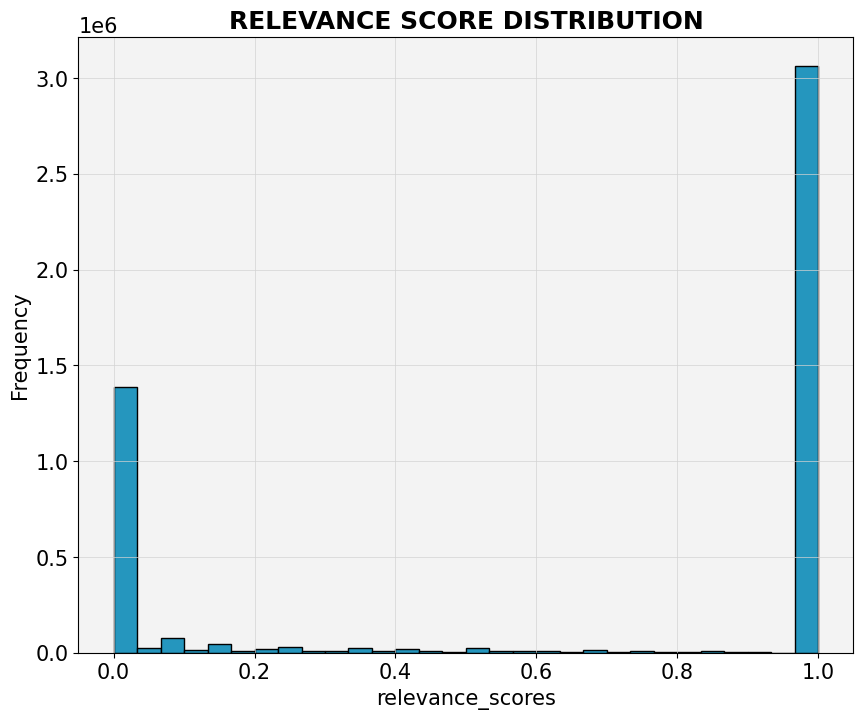

In [31]:
create_histogram(relavence_scores['relavence_score'],xname='relevance_scores', n_bins=30, title='Relevance Score Distribution')

In [32]:
relavence_scores.head()

,anime_id,Name,user_id,relavence_score
0,1,Cowboy Bebop,3,1.000000
1,1,Cowboy Bebop,6,1.000000
2,1,Cowboy Bebop,8,0.230769
3,1,Cowboy Bebop,13,0.000000
4,1,Cowboy Bebop,14,0.500000


In [33]:
anime_info_df_final.head(2)

,anime_id,ANIME_FEATURE IS_TV,ANIME_FEATURE YEAR_AIRED,ANIME_FEATURE IS_ADULT,ANIME_FEATURE ABOVE_FIVE_STAR_USERS,ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS,ANIME_FEATURE ABOVE_FIVE_STAR_RATIO,ANIME_FEATURE COMEDY,ANIME_FEATURE ACTION,ANIME_FEATURE FANTASY,ANIME_FEATURE ADVENTURE,ANIME_FEATURE KIDS,ANIME_FEATURE DRAMA,ANIME_FEATURE SCI-FI,ANIME_FEATURE MUSIC,ANIME_FEATURE SHOUNEN,ANIME_FEATURE SLICE OF LIFE
0,1,1,1998.0,1,4012.0,4012.0,0.594018,1,1,0,1,0,1,1,0,0,0
1,5,0,2001.0,1,NaN,NaN,NaN,0,1,0,0,0,1,1,0,0,0


In the above code snippet, I have done the following steps,

- Dropped all the columns which have more than 50% null values.
- Sorted dataset based on user_id. Otherwise, a group parameter will have inconsistent groups everywhere.
- After sorting the dataset, I declared the last 100,000 rows as validation data and the rest as training data.
- Since the LightGBM model expects integers as target values, I have scaled the target between 1–10 and converted it to an integer. ( If you want, try converting it to 0 or 1 based on the threshold).
- Defined the groups parameter for train and tes data

In [34]:
train_interim = relavence_scores.merge(anime_info_df_final)
train = train_interim.merge(user_info,how='inner')

In [35]:
na_counts = (train.isna().sum() * 100/len(train))
na_counts

anime_id                                  0.000000
Name                                      0.000000
user_id                                   0.000000
relavence_score                           0.000000
ANIME_FEATURE IS_TV                       0.000000
ANIME_FEATURE YEAR_AIRED                  0.082642
ANIME_FEATURE IS_ADULT                    0.000000
ANIME_FEATURE ABOVE_FIVE_STAR_USERS      47.565174
ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS    47.565174
ANIME_FEATURE ABOVE_FIVE_STAR_RATIO      47.565174
ANIME_FEATURE COMEDY                      0.000000
ANIME_FEATURE ACTION                      0.000000
ANIME_FEATURE FANTASY                     0.000000
ANIME_FEATURE ADVENTURE                   0.000000
ANIME_FEATURE KIDS                        0.000000
ANIME_FEATURE DRAMA                       0.000000
ANIME_FEATURE SCI-FI                      0.000000
ANIME_FEATURE MUSIC                       0.000000
ANIME_FEATURE SHOUNEN                     0.000000
ANIME_FEATURE SLICE OF LIFE    

In [38]:
train_processed = train.drop(na_counts[na_counts > 50].index,axis=1)

In [39]:
train_processed.sort_values(by='user_id',inplace=True)

In [40]:
train_processed.columns

Index(['anime_id', 'Name', 'user_id', 'relavence_score', 'ANIME_FEATURE IS_TV',
       'ANIME_FEATURE YEAR_AIRED', 'ANIME_FEATURE IS_ADULT',
       'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE COMEDY',
       'ANIME_FEATURE ACTION', 'ANIME_FEATURE FANTASY',
       'ANIME_FEATURE ADVENTURE', 'ANIME_FEATURE KIDS', 'ANIME_FEATURE DRAMA',
       'ANIME_FEATURE SCI-FI', 'ANIME_FEATURE MUSIC', 'ANIME_FEATURE SHOUNEN',
       'ANIME_FEATURE SLICE OF LIFE', 'USER_FEATURE REVIEW_COUNT',
       'USER_FEATURE AVG_SCORE', 'USER_FEATURE SCORE_STDDEV',
       'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
       'USER_FEATURE ABOVE_FIVE_STAR_RATIO'],
      dtype='object')

In [41]:
train_processed.set_index("user_id",inplace=True)

In [44]:
train_processed.head(2)

,anime_id,Name,relavence_score,ANIME_FEATURE IS_TV,ANIME_FEATURE YEAR_AIRED,ANIME_FEATURE IS_ADULT,ANIME_FEATURE ABOVE_FIVE_STAR_USERS,ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS,ANIME_FEATURE ABOVE_FIVE_STAR_RATIO,ANIME_FEATURE COMEDY,...,ANIME_FEATURE DRAMA,ANIME_FEATURE SCI-FI,ANIME_FEATURE MUSIC,ANIME_FEATURE SHOUNEN,ANIME_FEATURE SLICE OF LIFE,USER_FEATURE REVIEW_COUNT,USER_FEATURE AVG_SCORE,USER_FEATURE SCORE_STDDEV,USER_FEATURE ABOVE_FIVE_STAR_COUNT,USER_FEATURE ABOVE_FIVE_STAR_RATIO
user_id,,,,,,,,,,,,,,,,,,,,,
0,4086,Muka Muka Paradise,1.0,1,1993.0,0,16.0,16.0,0.571429,1,...,0,0,0,0,0,71,4.732394,3.935036,NaN,NaN
0,1985,UFO Robo Grendizer,0.0,1,1975.0,0,NaN,NaN,NaN,0,...,0,1,0,1,0,71,4.732394,3.935036,NaN,NaN


In [45]:
features = ['ANIME_FEATURE IS_TV',
       'ANIME_FEATURE YEAR_AIRED', 'ANIME_FEATURE IS_ADULT',
       'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
       'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 'ANIME_FEATURE COMEDY',
       'ANIME_FEATURE ACTION', 'ANIME_FEATURE FANTASY',
       'ANIME_FEATURE ADVENTURE', 'ANIME_FEATURE KIDS', 'ANIME_FEATURE DRAMA',
       'ANIME_FEATURE SCI-FI', 'ANIME_FEATURE MUSIC', 'ANIME_FEATURE SHOUNEN',
       'ANIME_FEATURE SLICE OF LIFE', 'USER_FEATURE REVIEW_COUNT',
       'USER_FEATURE AVG_SCORE', 'USER_FEATURE SCORE_STDDEV',
       'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
       'USER_FEATURE ABOVE_FIVE_STAR_RATIO']

target = 'relavence_score'

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score,coverage_error

In [47]:
test_size = int(1e5)
X,y = train_processed[features],train_processed[target].apply(lambda x:int(x*10))
test_idx_start = len(X)-test_size

xtrain,xtest,ytrain,ytest = X.iloc[0:test_idx_start],X.iloc[test_idx_start:],y.iloc[0:test_idx_start],y.iloc[test_idx_start:]

In [49]:
get_group_size = lambda df: df.reset_index().groupby("user_id")['user_id'].count()

In [51]:
train_groups = get_group_size(xtrain)
test_groups = get_group_size(xtest)

In [53]:
train_groups[:3]

user_id
0     71
1    126
2    484
Name: user_id, dtype: int64

In [54]:
sum(train_groups) , sum(test_groups)

(4764372, 100000)

## Model Training

In [55]:
model = LGBMRanker(objective="lambdarank",n_estimators=20)
model.fit(xtrain,ytrain,group=train_groups,eval_set=[(xtest,ytest)],eval_group=[test_groups],eval_metric=['map'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total groups: 14841, total data: 4764372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.083848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2118
[LightGBM] [Info] Number of data points in the train set: 4764372, number of used features: 21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total groups: 322, total data: 100000


LGBMRanker(n_estimators=20, objective='lambdarank')

There is one more critical point to notice here. That is, how the model predictions are calculated. I was confused because when calling the .predict method, it does not expect additional parameters such as group. So I found below information from GitHub issues. According to the creator of LightGBM mentioned in this issue, LightGBM's lambdarank uses a pointwise approach to generate predictions. Meaning we do not want to provide additional parameters such as group. We can call the .predict() method with the correct feature vector.

However, since we are developing the LTR model, it's essential to have some candidate products and rank those according to the predicted relevance score. To generate candidate animes, I will use a straightforward method here. That is, select the animes that are not exposed to a given user. Select an N random subset from unexposed animes. Generate features based on user and selected N anime subset. Finally, use generated feature vector to get the relevance score and sort animes based on the relevance score. But in real-world use cases, we should use some meaningful methodologies. As an example, you can generate candidates as follows,

1. Select the user's favourite N number of genres.
2. For each genre in the above-selected genres, pick the highest-rated m animes. Now you have M* N animes to rank for that user. Just create the user base and anime-based features. And finally, call the .predict() method with the created feature vector.

In [58]:
relavence_scores.head(2)

,anime_id,Name,user_id,relavence_score
0,1,Cowboy Bebop,3,1.0
1,1,Cowboy Bebop,6,1.0


In [59]:
user_2_anime_df = relavence_scores.groupby("user_id").agg({"anime_id":lambda x:list(set(x))})
user_2_anime_df.head()

,anime_id
user_id,
0,"[256, 3457, 134, 269, 272, 19, 1047, 24, 1689,..."
1,"[3588, 39940, 22535, 31240, 35847, 35849, 2817..."
2,"[12293, 22535, 36876, 22543, 14353, 19, 36885,..."
3,"[1, 12291, 28677, 22535, 30727, 14345, 18, 616..."
4,"[2563, 1029, 1542, 16, 530, 1043, 3091, 1562, ..."


In [64]:
user_2_anime_map = dict(zip(user_2_anime_df.index,user_2_anime_df['anime_id']))

In [60]:
candidate_pool = anime_info_df_final['anime_id'].unique().tolist()
candidate_pool[:3]

[1, 5, 6]

In [61]:
def candidate_generation(user_id,candidate_pool,user_2_anime_map,N):
    # get all the interacted anime id list
    already_interacted = user_2_anime_map[user_id]
    # remove the already interacted anime from candidates
    candidates = list(set(candidate_pool) - set(already_interacted))
    # return the already interacted and N random candidates
    return already_interacted,np.random.choice(candidates,size=N)

In [62]:
anime_id_2_name = relavence_scores.drop_duplicates(subset=["anime_id","Name"])[['anime_id',"Name"]]
anime_id_2_name_map = dict(zip(anime_id_2_name['anime_id'],anime_id_2_name['Name']))
anime_id_2_name_map[1]

'Cowboy Bebop'

In [84]:
def generate_predictions(user_id,user_2_anime_map,candidate_pool,feature_columns,anime_id_2_name_map,ranker,N=100):
    """
    parameter:
      - user_id : prediction for this user_id
      - user_2_anime_map : dictionary (key = user_id, value = list of anime that user has interacted)
      - candidate_pool(list) : list of all anime id
      - features(list) : feature name of anime and user
      - anime_id_2_name_map (dict) : key = anime_id and value = anime_name
      - ranker : model
      - N : 10
    """
    # obtain already liked and cadidates from candidate generation
    already_liked,candidates = candidate_generation(user_id,candidate_pool,user_2_anime_map,N=10000)
    candidates_df = pd.DataFrame(data=pd.Series(candidates,name='anime_id'))
    features = anime_info_df_final.merge(candidates_df, how="inner")
    features['user_id'] = user_id
    features = features.merge(user_info)

    already_liked = list(already_liked)
    if len(already_liked) < len(candidates):
        append_list = np.full(fill_value=-1,shape=(len(candidates)-len(already_liked)))
        already_liked.extend(list(append_list))

    print(type(features))
    display(features.head())
    predictions = pd.DataFrame(index=candidates)
    predictions['name'] = np.array([anime_id_2_name_map.get(id_) for id_ in candidates])
    predictions['score'] = ranker.predict(features[feature_columns])
    predictions = predictions.sort_values(by='score',ascending=False).head(N)

    predictions[f'already_liked - sample[{N}]'] = [anime_id_2_name_map.get(id_) for id_ in already_liked[0:len(predictions)]]
    return predictions

In [85]:
print_tabulate(generate_predictions(123,user_2_anime_map,candidate_pool,feature_columns=features,anime_id_2_name_map=anime_id_2_name_map,ranker=model,N=10))

<class 'pandas.core.frame.DataFrame'>


,anime_id,ANIME_FEATURE IS_TV,ANIME_FEATURE YEAR_AIRED,ANIME_FEATURE IS_ADULT,ANIME_FEATURE ABOVE_FIVE_STAR_USERS,ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS,ANIME_FEATURE ABOVE_FIVE_STAR_RATIO,ANIME_FEATURE COMEDY,ANIME_FEATURE ACTION,ANIME_FEATURE FANTASY,...,ANIME_FEATURE SCI-FI,ANIME_FEATURE MUSIC,ANIME_FEATURE SHOUNEN,ANIME_FEATURE SLICE OF LIFE,user_id,USER_FEATURE REVIEW_COUNT,USER_FEATURE AVG_SCORE,USER_FEATURE SCORE_STDDEV,USER_FEATURE ABOVE_FIVE_STAR_COUNT,USER_FEATURE ABOVE_FIVE_STAR_RATIO
0,1,1,1998.0,1,4012.0,4012.0,0.594018,1,1,0,...,1,0,0,0,123,139,6.496403,2.624782,117.0,0.841727
1,1,1,1998.0,1,4012.0,4012.0,0.594018,1,1,0,...,1,0,0,0,123,139,6.496403,2.624782,117.0,0.841727
2,5,0,2001.0,1,NaN,NaN,NaN,0,1,0,...,1,0,0,0,123,139,6.496403,2.624782,117.0,0.841727
3,18,1,2004.0,0,613.0,613.0,0.656317,0,1,0,...,0,0,0,0,123,139,6.496403,2.624782,117.0,0.841727
4,18,1,2004.0,0,613.0,613.0,0.656317,0,1,0,...,0,0,0,0,123,139,6.496403,2.624782,117.0,0.841727


+-------+-------------------------------------------------------------------+---------+------------------------------+
|       | name                                                              |   score | already_liked - sample[10]   |
|-------+-------------------------------------------------------------------+---------+------------------------------|
|  1348 | Bubblegum Crash                                                   | 2.14745 | Majo no Takkyuubin           |
| 15617 | Jinrui wa Suitai Shimashita Specials                              | 2.14745 | Tenkuu no Shiro Laputa       |
| 20177 | Gin no Otoko                                                      | 2.14745 | Pumpkin Scissors             |
| 42030 | Fate/kaleid liner Prisma☆Illya Movie: Licht - Namae no Nai Shoujo | 2.11424 | Omoide Poroporo              |
| 42955 | Hallelujah: Unmei no Sentaku                                      | 2.11424 | Heisei Tanuki Gassen Ponpoko |
|  2095 | Salamander                            

In [78]:
def generate_shap_plots(ranker, X_train, feature_names, N=3):
    """
    Generates SHAP plots for a pre-trained LightGBM model.

    Parameters:
        ranker (lightgbm.Booster): A trained LightGBM model
        X_train (np.ndarray): The training data used to fit the model
        feature_names (List): list of feature names
        N (int): The number of plots to generate

    Returns:
        None
    """
    explainer = shap.Explainer(ranker, X_train, feature_names=feature_names)
    shap_values = explainer(X_train.iloc[:N])

    # Create a figure with 2 subplots
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    # Plot the summary plot on the first subplot
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='bar')

    print()
    # Plot the feature importance plot on the second subplot
    plt.subplot(1, 2, 2)
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')

    plt.show()

 91%|==================  | 9065/10000 [00:13<00:01]       

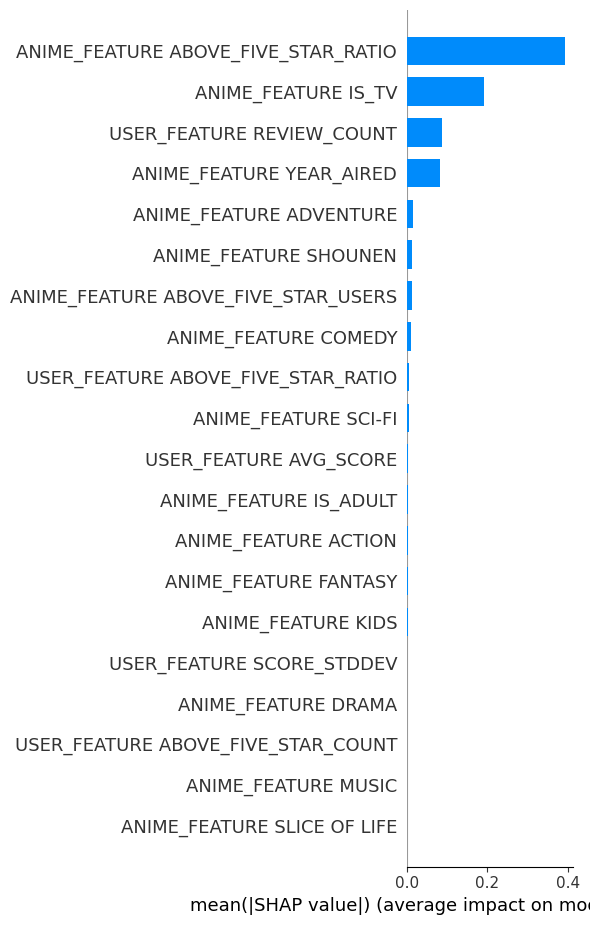

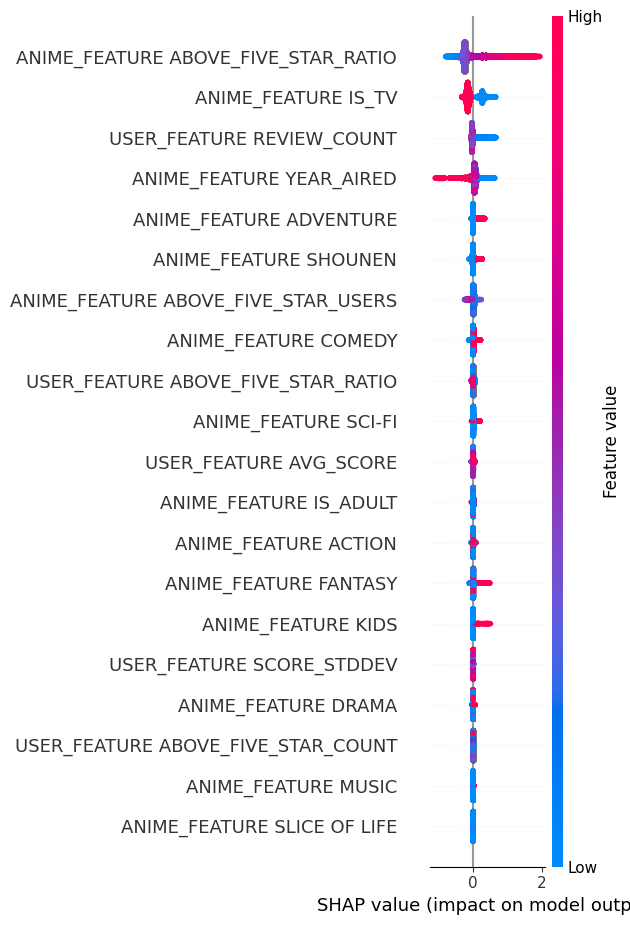

In [79]:
generate_shap_plots(model,xtrain,features,N=10000)